In [27]:
# Install required libraries
!pip install yfinance pandas numpy matplotlib plotly requests pmdarima scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00


# Fetching Stock Data

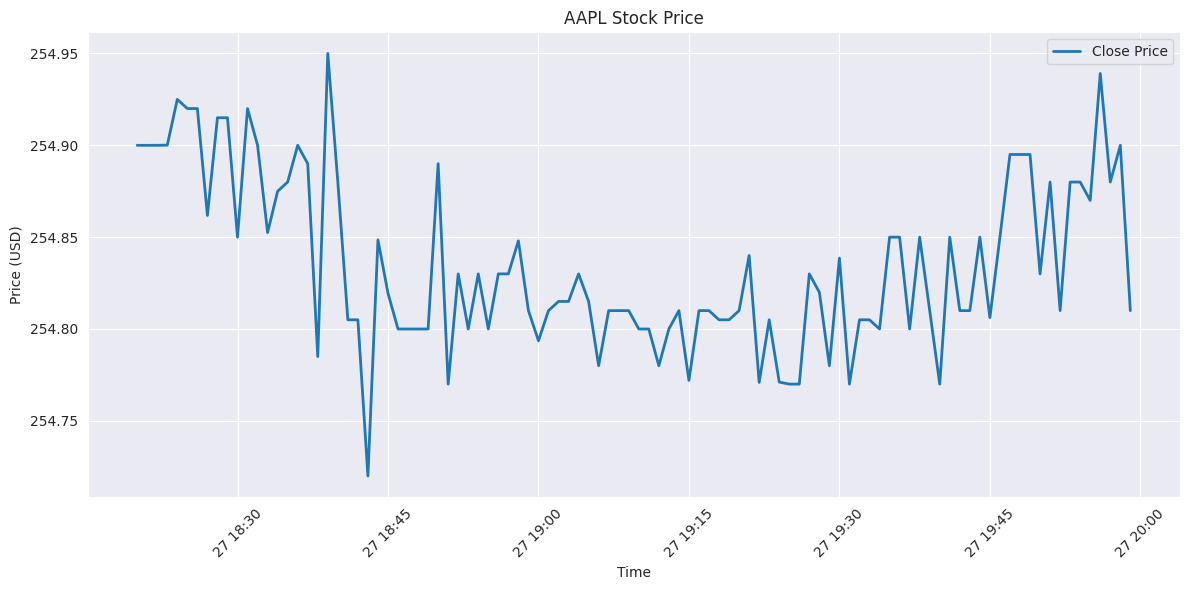

In [8]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class StockDataFetcher:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"

    def fetch_intraday_data(self, symbol, interval="1min"):
        params = {
            "function": "TIME_SERIES_INTRADAY",
            "symbol": symbol,
            "interval": interval,
            "apikey": self.api_key
        }

        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()

            data = response.json()

            if "Error Message" in data:
                return f"Error: {data['Error Message']}"
            elif "Note" in data:
                return f"API limit reached: {data['Note']}"

            time_series_key = f"Time Series ({interval})"
            if time_series_key not in data:
                return "Error: No time series data found"

            df = pd.DataFrame.from_dict(data[time_series_key], orient="index")
            df.columns = [col.split(". ")[1] for col in df.columns]
            df = df.astype(float)
            df.index = pd.to_datetime(df.index)

            return df

        except requests.exceptions.RequestException as e:
            return f"Network error: {str(e)}"
        except Exception as e:
            return f"Error processing data: {str(e)}"

    def plot_stock_data(self, df, symbol):
        plt.figure(figsize=(12, 6))
        sns.set_style("darkgrid")
        plt.plot(df.index, df['close'], label='Close Price', linewidth=2)
        plt.title(f'{symbol} Stock Price')
        plt.xlabel('Time')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    API_KEY = "68UGEXMTUAK8CGCF"
    fetcher = StockDataFetcher(API_KEY)

    symbol = "AAPL"
    stock_data = fetcher.fetch_intraday_data(symbol)

    if isinstance(stock_data, pd.DataFrame):
        fetcher.plot_stock_data(stock_data, symbol)
    else:
        print(f"Error: {stock_data}")

Trading Strategy with Multiple Indicators

In [9]:
!pip install yfinance pandas numpy matplotlib seaborn


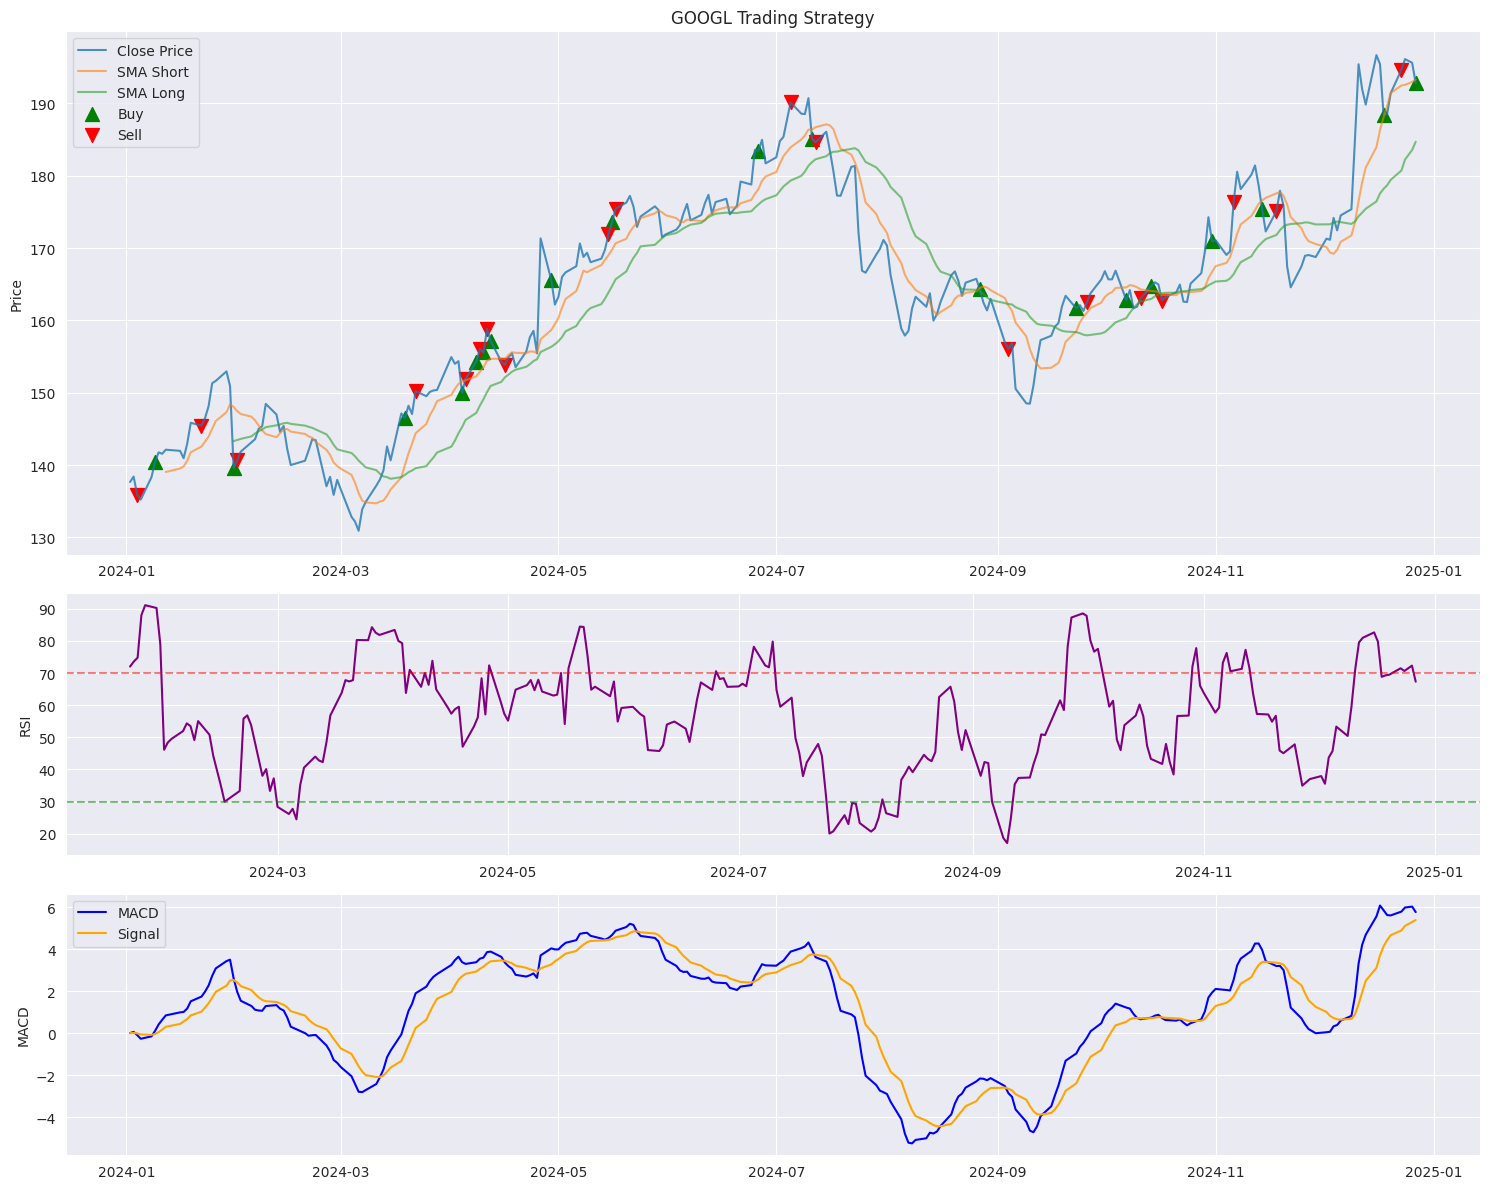

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class TradingStrategy:
    def __init__(self, symbol, start_date=None, end_date=None):
        self.symbol = symbol
        self.start_date = start_date or (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
        self.end_date = end_date or datetime.now().strftime('%Y-%m-%d')

    def fetch_data(self):
        stock = yf.Ticker(self.symbol)
        data = stock.history(start=self.start_date, end=self.end_date, interval='1d')
        return data

    def generate_signals(self, data, short_window=9, long_window=21, rsi_period=14, rsi_upper=70, rsi_lower=30):
        df = data.copy()

        # Calculate SMAs
        df['SMA_Short'] = df['Close'].rolling(window=short_window).mean()
        df['SMA_Long'] = df['Close'].rolling(window=long_window).mean()

        # Calculate RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

        # Generate signals
        df['Signal'] = 0

        # Combined trading conditions
        buy_conditions = (
            (df['SMA_Short'] > df['SMA_Long']) &
            (df['RSI'] < rsi_lower) &
            (df['MACD'] > df['Signal_Line'])
        )

        sell_conditions = (
            (df['SMA_Short'] < df['SMA_Long']) |
            (df['RSI'] > rsi_upper) |
            (df['MACD'] < df['Signal_Line'])
        )

        df.loc[buy_conditions, 'Signal'] = 1
        df.loc[sell_conditions, 'Signal'] = -1
        df['Position'] = df['Signal'].diff()

        return df

    def plot_strategy(self, data):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])

        # Price and SMAs
        ax1.plot(data.index, data['Close'], label='Close Price', alpha=0.8)
        ax1.plot(data.index, data['SMA_Short'], label=f'SMA Short', alpha=0.6)
        ax1.plot(data.index, data['SMA_Long'], label=f'SMA Long', alpha=0.6)

        # Signals
        buy_signals = data[data['Position'] == 1]
        sell_signals = data[data['Position'] == -1]

        ax1.scatter(buy_signals.index, buy_signals['Close'],
                   marker='^', color='green', s=100, label='Buy')
        ax1.scatter(sell_signals.index, sell_signals['Close'],
                   marker='v', color='red', s=100, label='Sell')

        ax1.set_title(f'{self.symbol} Trading Strategy')
        ax1.set_ylabel('Price')
        ax1.grid(True)
        ax1.legend()

        # RSI
        ax2.plot(data.index, data['RSI'], color='purple')
        ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
        ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
        ax2.set_ylabel('RSI')
        ax2.grid(True)

        # MACD
        ax3.plot(data.index, data['MACD'], label='MACD', color='blue')
        ax3.plot(data.index, data['Signal_Line'], label='Signal', color='orange')
        ax3.set_ylabel('MACD')
        ax3.grid(True)
        ax3.legend()

        plt.tight_layout()
        plt.show()

# Run strategy
symbol = 'GOOGL'
strategy = TradingStrategy(symbol)
data = strategy.fetch_data()
signals_df = strategy.generate_signals(data)
strategy.plot_strategy(signals_df)

Algorithm Implementation

In [26]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

class TradingStrategy:
    def __init__(self, symbol, start_date=None, end_date=None, stop_loss_pct=0.02, take_profit_pct=0.04):
        self.symbol = symbol
        self.start_date = start_date or (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
        self.end_date = end_date or datetime.now().strftime('%Y-%m-%d')
        self.stop_loss_pct = stop_loss_pct  # Stop-loss as percentage
        self.take_profit_pct = take_profit_pct  # Take-profit as percentage

    def fetch_data(self):
        stock = yf.Ticker(self.symbol)
        data = stock.history(start=self.start_date, end=self.end_date, interval='1d')
        return data

    def generate_signals(self, data, short_window=9, long_window=21, rsi_period=14, rsi_upper=60, rsi_lower=40):
        df = data.copy()

        # Calculate EMAs
        df['EMA_Short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
        df['EMA_Long'] = df['Close'].ewm(span=long_window, adjust=False).mean()

        # Calculate RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Calculate Bollinger Bands
        df['BB_Mid'] = df['Close'].rolling(window=20).mean()
        df['BB_Upper'] = df['BB_Mid'] + 2 * df['Close'].rolling(window=20).std()
        df['BB_Lower'] = df['BB_Mid'] - 2 * df['Close'].rolling(window=20).std()

        # Generate signals
        df['Signal'] = 0

        # Buy Condition: EMA Short > EMA Long, RSI < rsi_lower, and Close near BB Mid
        buy_conditions = (
            (df['EMA_Short'] > df['EMA_Long']) &
            (df['RSI'] < rsi_lower) &
            (df['Close'] <= df['BB_Mid'])
        )

        # Sell Condition: EMA Short < EMA Long, RSI > rsi_upper, and Close near BB Mid
        sell_conditions = (
            (df['EMA_Short'] < df['EMA_Long']) &
            (df['RSI'] > rsi_upper) &
            (df['Close'] >= df['BB_Mid'])
        )

        df.loc[buy_conditions, 'Signal'] = 1
        df.loc[sell_conditions, 'Signal'] = -1
        df['Position'] = df['Signal'].diff()

        # Add stop-loss and take-profit levels
        df['Stop_Loss'] = df['Close'] * (1 - self.stop_loss_pct)
        df['Take_Profit'] = df['Close'] * (1 + self.take_profit_pct)

        # Debugging output
        print(df[['EMA_Short', 'EMA_Long', 'RSI', 'BB_Upper', 'BB_Lower']].tail())

        return df

    def plot_strategy(self, data):
        buy_signals = data[data['Position'] == 1]
        sell_signals = data[data['Position'] == -1]

        # Plotly Figure
        fig = go.Figure()

        # Add candlestick chart
        fig.add_trace(go.Candlestick(
            x=data.index,
            open=data['Open'],
            high=data['High'],
            low=data['Low'],
            close=data['Close'],
            name='Candlestick'))

        # Add EMA lines
        fig.add_trace(go.Scatter(x=data.index, y=data['EMA_Short'], mode='lines', name='EMA Short'))
        fig.add_trace(go.Scatter(x=data.index, y=data['EMA_Long'], mode='lines', name='EMA Long'))

        # Add Bollinger Bands
        fig.add_trace(go.Scatter(x=data.index, y=data['BB_Upper'], mode='lines', name='BB Upper', line=dict(dash='dot')))
        fig.add_trace(go.Scatter(x=data.index, y=data['BB_Lower'], mode='lines', name='BB Lower', line=dict(dash='dot')))

        # Add Buy signals
        fig.add_trace(go.Scatter(
            x=buy_signals.index,
            y=buy_signals['Close'],
            mode='markers',
            marker=dict(color='green', size=10, symbol='triangle-up'),
            name='Buy Signal'))

        # Add Sell signals
        fig.add_trace(go.Scatter(
            x=sell_signals.index,
            y=sell_signals['Close'],
            mode='markers',
            marker=dict(color='red', size=10, symbol='triangle-down'),
            name='Sell Signal'))

        # Improved Layout
        fig.update_layout(
            title=f'{self.symbol} Trading Strategy with Adjusted Thresholds',
            xaxis_title='Date',
            yaxis_title='Price',
            template='plotly_dark',
            legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
            xaxis_rangeslider_visible=False
        )

        fig.show()

        # Explanation of signals
        print("\nTrading Signals Explanation:")
        print("Buy Signal:")
        print("- EMA Short crosses above EMA Long.")
        print("- RSI is below the oversold threshold (40).")
        print("- Close price is near or below the Bollinger Band midline.")
        print("\nSell Signal:")
        print("- EMA Short crosses below EMA Long.")
        print("- RSI is above the overbought threshold (60).")
        print("- Close price is near or above the Bollinger Band midline.")

        # Display dates and times for buy and sell signals
        print("\nBuy Signals:")
        print(buy_signals[['Close', 'Stop_Loss', 'Take_Profit']])
        print("\nSell Signals:")
        print(sell_signals[['Close', 'Stop_Loss', 'Take_Profit']])

# Interactive section for Google Colab
print("Enter the stock symbol (e.g., AAPL, GOOGL):")
symbol = input("Stock Symbol: ")

# Run strategy
strategy = TradingStrategy(symbol, start_date='2015-01-01')
data = strategy.fetch_data()
signals_df = strategy.generate_signals(data)
strategy.plot_strategy(signals_df)


Enter the stock symbol (e.g., AAPL, GOOGL):
Stock Symbol: META
                            EMA_Short    EMA_Long        RSI    BB_Upper  \
Date                                                                       
2024-12-20 00:00:00-05:00  604.971284  600.806113  47.172536  648.087541   
2024-12-23 00:00:00-05:00  603.947022  600.719191  44.427744  645.668982   
2024-12-24 00:00:00-05:00  604.707618  601.358356  47.823485  643.724691   
2024-12-26 00:00:00-05:00  604.436089  601.539412  47.991850  642.105880   
2024-12-27 00:00:00-05:00  603.510871  601.382193  39.838860  638.968299   

                             BB_Lower  
Date                                   
2024-12-20 00:00:00-05:00  554.453206  
2024-12-23 00:00:00-05:00  560.987824  
2024-12-24 00:00:00-05:00  567.241661  
2024-12-26 00:00:00-05:00  571.887699  
2024-12-27 00:00:00-05:00  578.132153  



Trading Signals Explanation:
Buy Signal:
- EMA Short crosses above EMA Long.
- RSI is below the oversold threshold (40).
- Close price is near or below the Bollinger Band midline.

Sell Signal:
- EMA Short crosses below EMA Long.
- RSI is above the overbought threshold (60).
- Close price is near or above the Bollinger Band midline.

Buy Signals:
                                Close   Stop_Loss  Take_Profit
Date                                                          
2015-04-10 00:00:00-04:00   81.727798   80.093242    84.996910
2015-04-17 00:00:00-04:00   80.472603   78.863151    83.691507
2015-05-28 00:00:00-04:00   79.844994   78.248094    83.038793
2015-06-03 00:00:00-04:00   82.126289   80.483764    85.411341
2015-08-10 00:00:00-04:00   93.791725   91.915891    97.543394
2015-08-13 00:00:00-04:00   93.074455   91.212966    96.797433
2015-08-20 00:00:00-04:00   90.215378   88.411070    93.823993
2015-09-14 00:00:00-04:00   91.958725   90.119550    95.637074
2016-01-29 00:00:00-